In [56]:
import pandas as pd
import numpy as np
import requests
import pandas as pd
import shap
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [101]:
start_date = datetime.strptime("2024-02-21", "%Y-%m-%d")
end_date = datetime.strptime("2024-03-20", "%Y-%m-%d")

# Initialize current date to start date
current_date = start_date

# Create an empty DataFrame to store all data
data = pd.DataFrame()

while current_date < end_date:
    # Define the end of the 7-day interval
    next_date = current_date + timedelta(days=6)

    # Download data for the 7-day interval
    temp = yf.download(
        "AAPL",
        start=current_date.strftime("%Y-%m-%d"),
        end=next_date.strftime("%Y-%m-%d"),
        interval="1m",
    ).reset_index()

    # Append the data to the all_data DataFrame
    data = pd.concat([data, temp])

    # Move to the next 7-day interval
    current_date = next_date

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [102]:
data["Close"].pct_change().describe()

count    8138.000000
mean       -0.000002
std         0.000688
min        -0.023816
25%        -0.000265
50%         0.000000
75%         0.000265
max         0.016573
Name: Close, dtype: float64

In [103]:
# Adjust the lag features to reflect a shorter timescale
for i in range(1, 5):
    data[f"Close_Lag_{i}"] = data["Close"].shift(i)
    data[f"Volume_Lag_{i}"] = data["Volume"].shift(i)

# Adjust the moving averages to reflect a shorter timescale
for i in [5, 10, 15]:
    data[f"SMA_{i}"] = data["Close"].rolling(window=i).mean()
    data[f"EMA_{i}"] = data["Close"].ewm(span=i, adjust=False).mean()

# RSI
delta = data["Close"].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=10).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=10).mean()
rs = gain / loss
data["RSI"] = 100 - (100 / (1 + rs))

# MACD
exp1 = data["Close"].ewm(span=6, adjust=False).mean()
exp2 = data["Close"].ewm(span=13, adjust=False).mean()
data["MACD"] = exp1 - exp2

# ATR
high_low = data["High"] - data["Low"]
high_close = (data["High"] - data["Close"].shift()).abs()
low_close = (data["Low"] - data["Close"].shift()).abs()
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
data["ATR"] = true_range.rolling(window=10).mean()

# Bollinger Bands
data["Middle_BB"] = data["Close"].rolling(window=10).mean()
data["Upper_BB"] = data["Middle_BB"] + 2 * data["Close"].rolling(window=10).std()
data["Lower_BB"] = data["Middle_BB"] - 2 * data["Close"].rolling(window=10).std()

# OBV
data["OBV"] = (np.sign(data["Close"].diff()) * data["Volume"]).fillna(0).cumsum()

# VWAP (assuming intraday data is available)
data["VWAP"] = (
    data["Volume"] * (data["High"] + data["Low"] + data["Close"]) / 3
).cumsum() / data["Volume"].cumsum()


# Stochastic Oscillator
low_min = data["Low"].rolling(window=14).min()
high_max = data["High"].rolling(window=14).max()
data["%K"] = 100 * (data["Close"] - low_min) / (high_max - low_min)

# CCI
TP = (data["High"] + data["Low"] + data["Close"]) / 3
data["CCI"] = (TP - TP.rolling(window=20).mean()) / (
    0.015 * TP.rolling(window=20).std()
)

# ADX
data["+DM"] = np.where(
    (data["High"] - data["High"].shift(1)) > (data["Low"].shift(1) - data["Low"]),
    data["High"] - data["High"].shift(1),
    0,
)
data["-DM"] = np.where(
    (data["Low"].shift(1) - data["Low"]) > (data["High"] - data["High"].shift(1)),
    data["Low"].shift(1) - data["Low"],
    0,
)
TR = pd.concat(
    [
        data["High"] - data["Low"],
        data["High"] - data["Close"].shift(1),
        data["Close"].shift(1) - data["Low"],
    ],
    axis=1,
).max(axis=1)
data["+DI"] = 100 * data["+DM"].ewm(span=14).mean() / TR
data["-DI"] = 100 * data["-DM"].ewm(span=14).mean() / TR
data["DX"] = 100 * abs((data["+DI"] - data["-DI"]) / (data["+DI"] + data["-DI"]))
data["ADX"] = data["DX"].rolling(window=14).mean()

# ROC
data["ROC"] = data["Close"].pct_change(periods=12)

In [104]:
data = data.dropna().reset_index(drop=True)

In [105]:
data["Future_Close"] = data["Close"].shift(-3)  # Shift by 10 intervals
data["Target"] = data["Future_Close"] > data["Close"].astype(int)
data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Close_Lag_1,Volume_Lag_1,Close_Lag_2,...,CCI,+DM,-DM,+DI,-DI,DX,ADX,ROC,Future_Close,Target
0,2024-02-21 09:49:00-05:00,182.710007,182.740005,182.404999,182.410004,182.410004,156112,182.710007,204615.0,182.729996,...,14.889747,0.000000,0.274994,18.720899,23.653852,11.641255,33.206322,-0.001205,182.600006,True
1,2024-02-21 09:50:00-05:00,182.399994,182.639999,182.370193,182.519302,182.519302,182323,182.410004,156112.0,182.710007,...,0.839049,0.000000,0.034805,19.984111,27.059574,15.040197,28.254558,0.000511,182.630005,True
2,2024-02-21 09:51:00-05:00,182.485001,182.570007,182.309998,182.360001,182.360001,131450,182.519302,182323.0,182.410004,...,-47.443826,0.000000,0.060196,17.848077,27.392580,21.097181,23.656237,0.000082,182.600006,True
3,2024-02-21 09:52:00-05:00,182.354294,182.610001,182.320007,182.600006,182.600006,114039,182.360001,131450.0,182.519302,...,-0.547629,0.039993,0.000000,15.696422,21.159099,14.821868,21.997890,0.001337,182.539993,True
4,2024-02-21 09:53:00-05:00,182.610001,182.740005,182.559998,182.630005,182.630005,133791,182.600006,114039.0,182.360001,...,56.927739,0.130005,0.000000,31.753455,29.390953,3.863807,19.122869,0.002140,182.529999,True


In [106]:
X = data.drop(["Target", "Future_Close"], axis=1)
y = data["Target"]

In [107]:
# split train and test by date
X_train = X.loc[X["Datetime"] < "2024-03-18"]
X_test = X.loc[X["Datetime"] >= "2024-03-18"]
y_train = y.loc[X["Datetime"] < "2024-03-18"]
y_test = y.loc[X["Datetime"] >= "2024-03-18"]

In [108]:
X_train.drop("Datetime", axis=1, inplace=True)
X_test.drop("Datetime", axis=1, inplace=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6546, number of negative: 404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 6950, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941871 -> initscore=2.785195
[LightGBM] [Info] Start training from score 2.785195


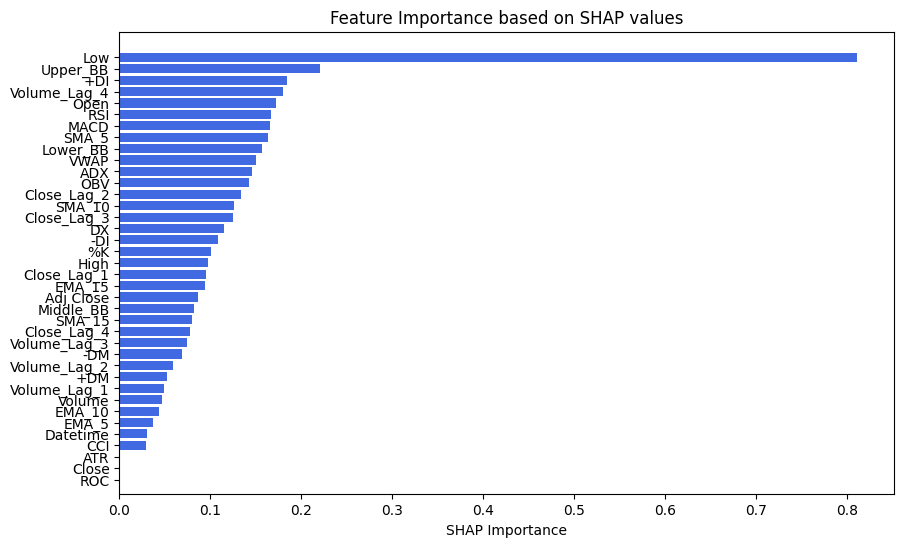

In [109]:
model = LGBMClassifier()
model.fit(X_train, y_train)

# Step 2: Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Assuming binary classification; adjust accordingly for multi-class
expected_value = (
    explainer.expected_value[1]
    if isinstance(explainer.expected_value, list)
    else explainer.expected_value
)
shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values

# Step 3: Summarize SHAP values in a DataFrame
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["feature", "shap_importance"]
importance_df["shap_importance"] = importance_df["shap_importance"].astype(float)
importance_df = importance_df.sort_values("shap_importance", ascending=False)

# Step 4: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["shap_importance"], color="royalblue")
plt.xlabel("SHAP Importance")
plt.title("Feature Importance based on SHAP values")
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

In [ ]:
top_5_features = importance_df.sort_values(by="shap_importance", ascending=False).head(
    5
)
selected_features = top_5_features["feature"].tolist()

In [ ]:
selected_features

In [51]:
# Assuming `selected_features` are the features selected through some feature selection process
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize and train the model using the selected features
model = LGBMClassifier(random_state=42)
model.fit(X_train_selected, y_train)

NameError: name 'selected_features' is not defined

In [110]:
# Predict on the test set
predictions = model.predict(X_test)

# Calculate accuracy or any other performance metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9333333333333333


In [ ]:
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (e.g., class "1")
probabilities = model.predict_proba(X_test_selected)[:, 1]

# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({"Actual": y_test, "Predicted": probabilities})

# Sort the DataFrame by predicted probabilities for better visualization
results_df = results_df.sort_values(by="Predicted")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["Predicted"].values,
    label="Predicted Probability of Class 1",
    color="blue",
)
plt.scatter(
    range(len(results_df)),
    results_df["Actual"].values,
    marker=".",
    label="Actual Outcome",
    color="red",
)

# Enhancing the plot
plt.title("Predicted Probabilities vs. Actual Outcomes")
plt.xlabel("Sample Index (sorted by predicted probability)")
plt.ylabel("Probability / Actual Outcome")
plt.legend()
plt.show()

In [111]:
import math
import warnings

warnings.filterwarnings("ignore")
from termcolor import colored as cl

In [112]:
def implement_strategy(df, investment, take_profit, stop_loss):

    in_position = False
    equity = investment
    no_of_shares = 0
    sell_at = None
    buy_price = None

    for i, row in df.iterrows():
        y_pred_proba = model.predict_proba([row.values])[0]
        current_price = df.Close[i]
        if y_pred_proba[1] > 0.9 and in_position == False:
            no_of_shares = math.floor(equity / current_price)
            equity -= no_of_shares * current_price
            in_position = True
            sell_at = i + 1
            buy_price = current_price
            print(
                cl("BUY: ", color="green", attrs=["bold"]),
                f"{no_of_shares} Shares are bought at ${current_price}",
            )
        elif i == sell_at and in_position == True:
            equity += no_of_shares * current_price
            in_position = False
            print(
                cl("SELL: ", color="red", attrs=["bold"]),
                f"{no_of_shares} Shares are sold at ${current_price}",
            )
            sell_at = None
        elif in_position == True and (
            (current_price - buy_price) / buy_price >= take_profit
            or (buy_price - current_price) / buy_price >= stop_loss
        ):
            equity += no_of_shares * current_price
            in_position = False
            print(
                cl("SELL: ", color="red", attrs=["bold"]),
                f"{no_of_shares} Shares are sold at ${current_price}",
            )
            sell_at = None
    if in_position == True:
        equity += no_of_shares * current_price
        print(
            cl(
                f"\nClosing position at {current_price}",
                attrs=["bold"],
            )
        )
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    # return roi
    print(cl(f"EARNING: ${earning} ; ROI: {roi}%", attrs=["bold"]))

In [113]:
implement_strategy(X_train, 100000, 0.03, 0.01)

BUY:  548 Shares are bought at $182.41000366210938
SELL:  548 Shares are sold at $182.51930236816406
BUY:  548 Shares are bought at $182.36000061035156
SELL:  548 Shares are sold at $182.60000610351562
BUY:  548 Shares are bought at $182.6300048828125
SELL:  548 Shares are sold at $182.60000610351562
BUY:  548 Shares are bought at $182.5399932861328
SELL:  548 Shares are sold at $182.52999877929688
BUY:  548 Shares are bought at $182.58999633789062
SELL:  548 Shares are sold at $182.4669952392578
BUY:  548 Shares are bought at $182.5399932861328
SELL:  548 Shares are sold at $182.4250030517578
BUY:  549 Shares are bought at $182.20150756835938
SELL:  549 Shares are sold at $182.45989990234375
BUY:  549 Shares are bought at $182.42999267578125
SELL:  549 Shares are sold at $182.67999267578125
BUY:  548 Shares are bought at $182.73500061035156
SELL:  548 Shares are sold at $182.75889587402344
BUY:  549 Shares are bought at $182.6320037841797
SELL:  549 Shares are sold at $182.52999877929

In [114]:
implement_strategy(X_test, 100000, 0.03, 0.01)

BUY:  570 Shares are bought at $175.42999267578125
SELL:  570 Shares are sold at $175.75
BUY:  569 Shares are bought at $175.77000427246094
SELL:  569 Shares are sold at $175.97500610351562
BUY:  569 Shares are bought at $176.01919555664062
SELL:  569 Shares are sold at $176.0050048828125
BUY:  568 Shares are bought at $176.27000427246094
SELL:  568 Shares are sold at $176.4600067138672
BUY:  569 Shares are bought at $176.44500732421875
SELL:  569 Shares are sold at $176.4550018310547
BUY:  569 Shares are bought at $176.35000610351562
SELL:  569 Shares are sold at $176.46009826660156
BUY:  567 Shares are bought at $176.94000244140625
SELL:  567 Shares are sold at $177.38499450683594
BUY:  568 Shares are bought at $177.02999877929688
SELL:  568 Shares are sold at $177.25
BUY:  568 Shares are bought at $177.4199981689453
SELL:  568 Shares are sold at $177.41000366210938
BUY:  568 Shares are bought at $177.52000427246094
SELL:  568 Shares are sold at $177.39599609375
BUY:  568 Shares are 